In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
from itertools import product

In [2]:
# energy specific fuel prices are not
SCENARIO = "dynamic" # "static" | "dynamic"

In [3]:
DATA = Path("..","data","processed", SCENARIO)
FIGURES = Path("..","figures","scatter", SCENARIO) 
SECTORS = ["E", "H", "EH"]
PRICES = ["high", "mid", "low", "vlow"]
EMISSIONS = ["20", "35", "50"]
EMISSION_NICE_NAMES = {
    "er20":"20% Reduction",
    "er35":"35% Reduction",
    "er50":"50% Reduction",
}
SECTOR_NICE_NAMES = {
    "E": "Electrical",
    "H": "Thermal",
    "EH": "Electrical and Thermal"
}
PRICE_NICE_NAMES = {
    "vlow": "Very Low",
    "low": "Low",
    "mid": "Mid",
    "high": "High"
}

In [4]:
def get_dataframe(emission: str, result: str, sector: Optional[str] = None, price: Optional[str] = None) -> pd.DataFrame:
    if not (sector or price):
        scenario = f"er{emission}"
    else:
        scenario = f"{sector}dr-{price}-er{emission}" 
    p = Path(DATA, scenario, "datapoint", f"{result}.csv")
    return pd.read_csv(p, index_col=0)

In [5]:
def get_scatter_data(result: str, metric: str) -> pd.DataFrame:
    
    data = {}
    
    for emission in EMISSIONS:
        e_data = []
        for sector, price in product(SECTORS, PRICES):
            costs = get_dataframe(
                emission=emission,
                result="cost",
                sector=sector,
                price=price
            )
            df = get_dataframe(
                emission=emission,
                result=result,
                sector=sector,
                price=price
            )
        
            obj = costs.at["objective", "value"] / 1e9
            datapoint = df.at[metric, "value"]
        
            e_data.append([obj, datapoint, sector, price])

        data[f"er{emission}"] = pd.DataFrame(
            e_data, 
            columns=[
                "Objective",
                metric,
                "Sector",
                "Price"
            ]
        )
    
    return data

In [6]:
def generate_scatterplot(data: dict[str, pd.DataFrame], ylabel: Optional[str] = None, **kwargs) -> tuple[plt.figure, plt.axes]:
    
    fig, axs = plt.subplots(1,3, sharey=True)
    
    ax = 0
    handles, labels = [], []
    
    for er, df in data.items():
        df["Sector"] = df.Sector.map(SECTOR_NICE_NAMES)
        df["Price"] = df.Price.map(PRICE_NICE_NAMES)
        metric = df.columns[1]
        scatter = sns.scatterplot(data=df, x="Objective", y=metric, hue="Sector", style="Price", ax=axs[ax], legend=True, s=50)
        axs[ax].set_title(EMISSION_NICE_NAMES[er])
        axs[ax].set_ylabel("")
        axs[ax].set_xlabel("")
        
        # Collect handles and labels for shared legend
        h, l = scatter.get_legend_handles_labels()
        if not handles:  # Avoid duplicates by only collecting from the first plot
            handles, labels = h, l
            
        axs[ax].legend_.remove()
        
        ax += 1

    fig.legend(
        handles, 
        labels, 
        loc="center left", 
        bbox_to_anchor=(1, 0.5),  # Position to the right of the figure
        ncol=1, 
        frameon=False,
    )
    
    fig.supxlabel("Objective Cost ($B)")
    if ylabel:
        fig.supylabel(ylabel)
    
    # plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    fig.tight_layout(rect=[0, 0, 1, 0.95]) 
    
    return fig, axs

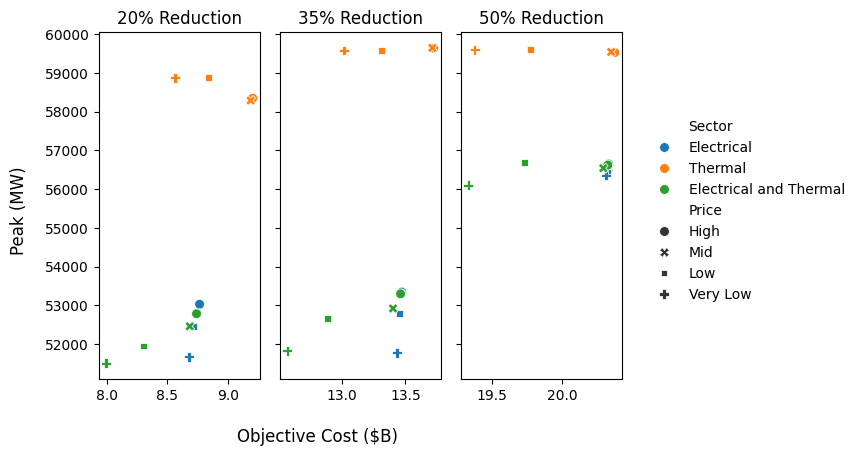

In [7]:
data = get_scatter_data("peakiness", "peak")
fig, _ = generate_scatterplot(data, ylabel = "Peak (MW)")
fig.savefig(Path(FIGURES, "peak_net_load.png"), bbox_inches="tight")

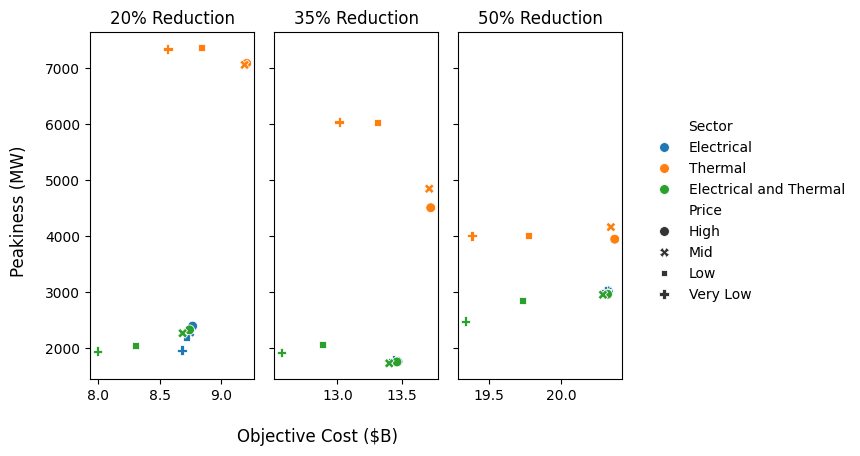

In [8]:
data = get_scatter_data("peakiness", "peakiness")
fig, _ = generate_scatterplot(data, ylabel = "Peakiness (MW)")
fig.savefig(Path(FIGURES, "peakiness.png"), bbox_inches="tight")

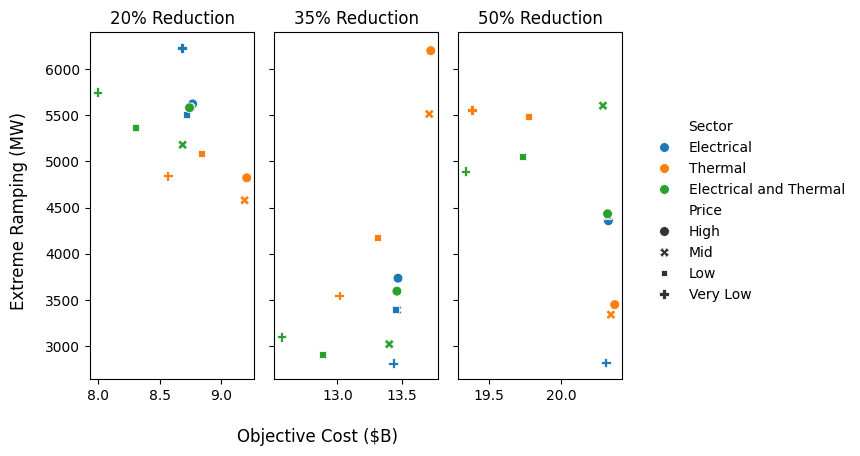

In [9]:
data = get_scatter_data("ramping", "extreme")
fig, _ = generate_scatterplot(data, ylabel = "Extreme Ramping (MW)")
fig.savefig(Path(FIGURES, "extreme_ramping.png"), bbox_inches="tight")

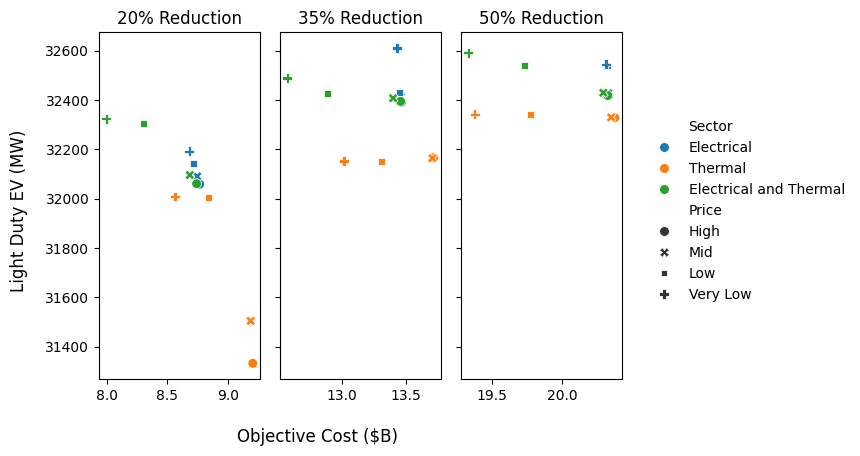

In [10]:
data = get_scatter_data("capacity", "Transport Electric Light")
fig, _ = generate_scatterplot(data, ylabel = "Light Duty EV (MW)")
fig.savefig(Path(FIGURES, "lgt_evs_capacity.png"), bbox_inches="tight")

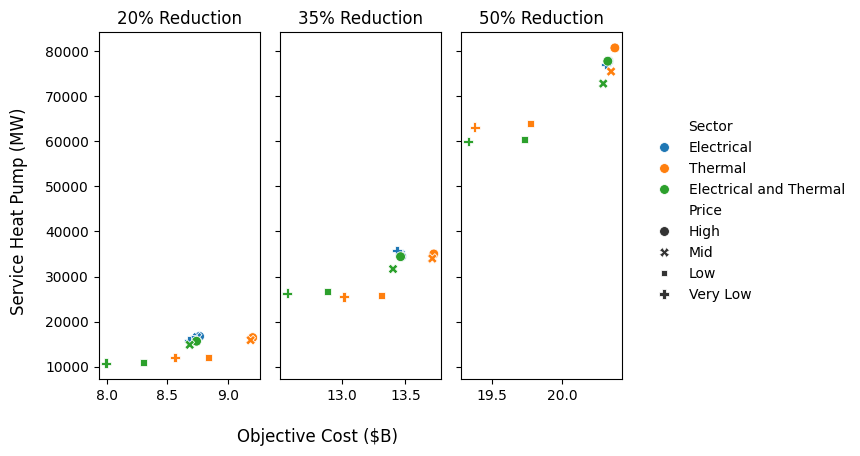

In [11]:
data = get_scatter_data("capacity", "Service Heat Pump")
fig, _ = generate_scatterplot(data, ylabel = "Service Heat Pump (MW)")
fig.savefig(Path(FIGURES, "service_heat_pump.png"), bbox_inches="tight")

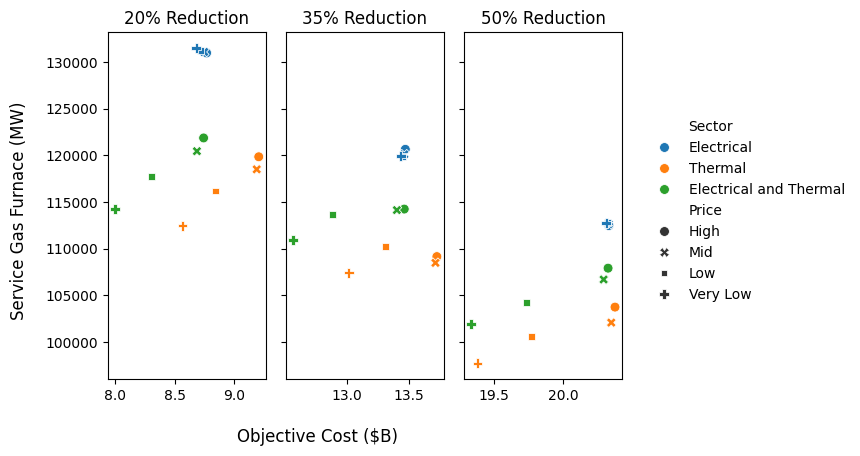

In [12]:
data = get_scatter_data("capacity", "Service Gas Furnace")
fig, _ = generate_scatterplot(data, ylabel = "Service Gas Furnace (MW)")
fig.savefig(Path(FIGURES, "service_gas_furnace.png"), bbox_inches="tight")

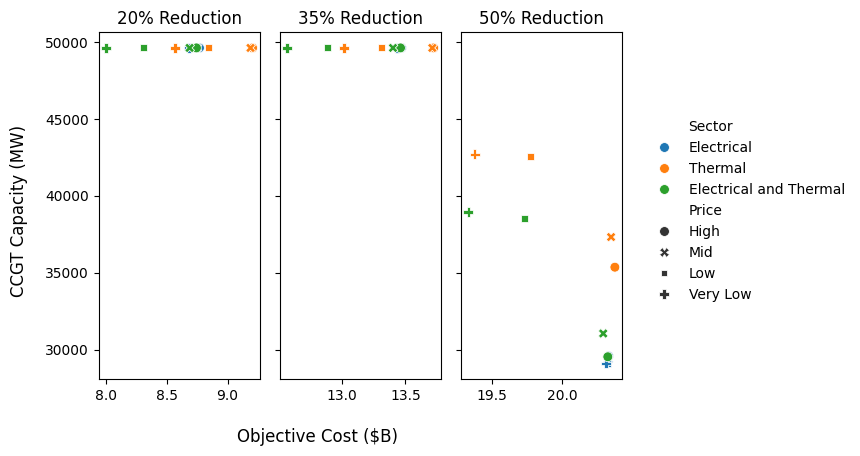

In [13]:
data = get_scatter_data("capacity", "Natural Gas CCGT")
fig, _ = generate_scatterplot(data, ylabel = "CCGT Capacity (MW)")
fig.savefig(Path(FIGURES, "ccgt_capacity.png"), bbox_inches="tight")

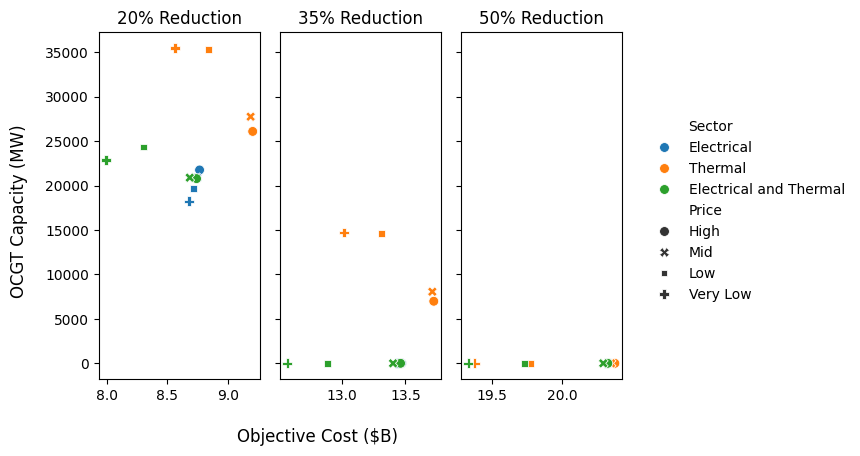

In [14]:
data = get_scatter_data("capacity", "Natural Gas OCGT")
fig, _ = generate_scatterplot(data, ylabel = "OCGT Capacity (MW)")
fig.savefig(Path(FIGURES, "ocgt_capacity.png"), bbox_inches="tight")

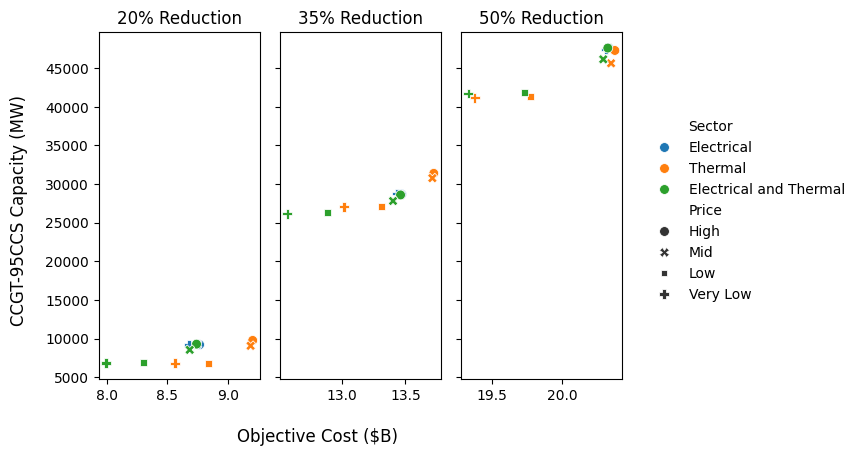

In [15]:
data = get_scatter_data("capacity", "Natural Gas CCGT-95CCS")
fig, _ = generate_scatterplot(data, ylabel = "CCGT-95CCS Capacity (MW)")
fig.savefig(Path(FIGURES, "ccgt95ccs_capacity.png"), bbox_inches="tight")

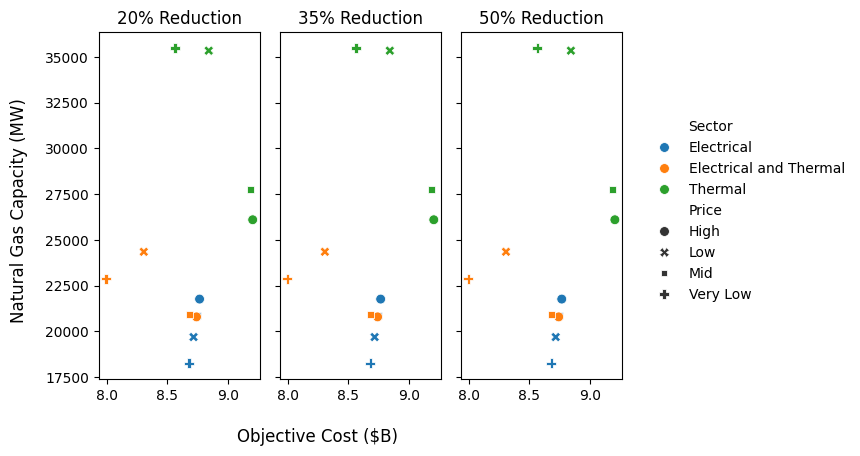

In [16]:
ocgt = get_scatter_data("capacity", "Natural Gas OCGT")
ccgt = get_scatter_data("capacity", "Natural Gas CCGT")
ccgtccs = get_scatter_data("capacity", "Natural Gas CCGT-95CCS")

data = {}

ocgt_er20 = ocgt["er20"]
ccgt_er20 = ocgt["er20"]
ccgtccs_er20 = ocgt["er20"]

ocgt_er35 = ocgt["er20"].set_index(["Sector", "Price"])
ccgt_er35 = ocgt["er20"].set_index(["Sector", "Price"])
ccgtccs_er35 = ocgt["er20"].set_index(["Sector", "Price"])

ocgt_er50 = ocgt["er20"].set_index(["Sector", "Price"])
ccgt_er50 = ocgt["er20"].set_index(["Sector", "Price"])
ccgtccs_er50 = ocgt["er20"].set_index(["Sector", "Price"])

er20 = pd.concat(
    [
        ocgt_er20.rename(columns={"Natural Gas OCGT":"Natural Gas"}),
        ccgt_er20, 
        ccgtccs_er20
    ], 
    axis=0
)
data["er20"] = (
    er20
    .groupby(["Sector", "Price"])
    .agg({"Objective":"mean", "Natural Gas":"sum"})
    .reset_index()
    [["Objective", "Natural Gas", "Sector", "Price"]]
)

er35 = pd.concat(
    [
        ocgt_er35.rename(columns={"Natural Gas OCGT":"Natural Gas"}),
        ccgt_er35, 
        ccgtccs_er35
    ], 
    axis=0
)
data["er35"] = (
    er35
    .groupby(["Sector", "Price"])
    .agg({"Objective":"mean", "Natural Gas":"sum"})
    .reset_index()
    [["Objective", "Natural Gas", "Sector", "Price"]]
)

er50 = pd.concat(
    [
        ocgt_er50.rename(columns={"Natural Gas OCGT":"Natural Gas"}),
        ccgt_er50, 
        ccgtccs_er50
    ], 
    axis=0
)
data["er50"] = (
    er50
    .groupby(["Sector", "Price"])
    .agg({"Objective":"mean", "Natural Gas":"sum"})
    .reset_index()
    [["Objective", "Natural Gas", "Sector", "Price"]]
)

fig, _ = generate_scatterplot(data, ylabel = "Natural Gas Capacity (MW)")
fig.savefig(Path(FIGURES, "total_ng_capacity.png"), bbox_inches="tight")